# Imports and Paths

In [3]:
import json
import os
import re
import string
import numpy as np
import pandas as pd
import glob
from sklearn.cluster import KMeans 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import pandas as pd
import re, nltk, spacy, gensim
# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV

# replace it with path on your desktop
root_path = '/home/siri/Downloads/CORD-19-research-challenge'
file_path = '/home/siri/Downloads/CORD-19-research-challenge/2020-03-13/all_sources_metadata_2020-03-13.csv'

/home/siri/anaconda3/envs/tfgpu/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Get Meta Data

In [9]:
meta_df = pd.read_csv(file_path)

In [10]:
meta_df.head()

,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_full_text
0,c630ebcdf30652f0422c3ec12a00b50241dc9bd9,CZI,Angiotensin-converting enzyme 2 (ACE2) as a SA...,10.1007/s00134-020-05985-9,NaN,32125455.0,cc-by-nc,NaN,2020,"Zhang, Haibo; Penninger, Josef M.; Li, Yimin; ...",Intensive Care Med,2.002765e+09,#3252,True
1,53eccda7977a31e3d0f565c884da036b1e85438e,CZI,Comparative genetic analysis of the novel coro...,10.1038/s41421-020-0147-1,NaN,NaN,cc-by,NaN,2020,"Cao, Yanan; Li, Lin; Feng, Zhimin; Wan, Shengq...",Cell Discovery,3.003431e+09,#1861,True
2,210a892deb1c61577f6fba58505fd65356ce6636,CZI,Incubation Period and Other Epidemiological Ch...,10.3390/jcm9020538,NaN,NaN,cc-by,The geographic spread of 2019 novel coronaviru...,2020,"Linton, M. Natalie; Kobayashi, Tetsuro; Yang, ...",Journal of Clinical Medicine,3.006065e+09,#1043,True
3,e3b40cc8e0e137c416b4a2273a4dca94ae8178cc,CZI,Characteristics of and Public Health Responses...,10.3390/jcm9020575,NaN,32093211.0,cc-by,"In December 2019, cases of unidentified pneumo...",2020,"Deng, Sheng-Qun; Peng, Hong-Juan",J Clin Med,1.776631e+08,#1999,True
4,92c2c9839304b4f2bc1276d41b1aa885d8b364fd,CZI,Imaging changes in severe COVID-19 pneumonia,10.1007/s00134-020-05976-w,NaN,32125453.0,cc-by-nc,NaN,2020,"Zhang, Wei",Intensive Care Med,3.006643e+09,#3242,False


In [11]:
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29500 entries, 0 to 29499
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   sha                          17420 non-null  object 
 1   source_x                     29500 non-null  object 
 2   title                        29130 non-null  object 
 3   doi                          26357 non-null  object 
 4   pmcid                        27337 non-null  object 
 5   pubmed_id                    16730 non-null  float64
 6   license                      17692 non-null  object 
 7   abstract                     26553 non-null  object 
 8   publish_time                 18248 non-null  object 
 9   authors                      28554 non-null  object 
 10  journal                      17791 non-null  object 
 11  Microsoft Academic Paper ID  1134 non-null   float64
 12  WHO #Covidence               1236 non-null   object 
 13  has_full_text   

# Get filenames of whitepapers

In [12]:
# these are in json format
all_json = glob.glob(f'{root_path}/**/*.json',recursive=True)
len(all_json)

13202

# Read main contents of each file

In [13]:
# Read paper id, abstract and body
class Json_reader:
    def __init__(self, file_path):
        with open(file_path) as file:
            content = json.load(file)
            self.paper_id = content['paper_id']
            self.abstract = []
            self.body_text = []
            for entry in content['abstract']:
                self.abstract.append(entry['text'])
            for entry in content['body_text']:
                self.body_text.append(entry['text'])
            self.abstract = '\n'.join(self.abstract)
            self.body_text = '\n'.join(self.body_text)
    def __repr__(self):
        return f'{self.paper_id} : {self.abstract[:200]}....{self.body_text[:200]}..'

# Peek into the first row

In [14]:
first_row = Json_reader(all_json[0])
print(first_row)

346f7bb753e53598554deae2f428d0ce66a8320a : A prospective study of a dromedary camel herd during the 2013-14 calving season showed Middle East respiratory syndrome coronavirus infection of calves and adults. Virus was isolated from the nose and....We studied dromedaries at 2 farms in Al-Hasa, 4-5 km apart. Farm A had 70 animals; 4 were 1 month of age, 8 were ≈1 year of age, and the rest were adults (>2 years of age). The herd did not go to past..


# Converting to a Dataframe

In [15]:
literature_dict = {'paper_id' :[],'abstract':[],'body_text':[],'title':[],'journal':[]}

for entry in all_json:
    content = Json_reader(entry)
    
    meta_info = meta_df.loc[meta_df['sha'] == content.paper_id]
    if len(meta_info) == 0:
        continue
    literature_dict['paper_id'].append(content.paper_id)
    literature_dict['abstract'].append(content.abstract)
    literature_dict['body_text'].append(content.body_text)
    
    #authors = meta_info['authors'].values[0]
    #if pd.isna(authors):
    #    literature_dict['authors'].append(authors)
    #else:
    #    literature_dict['authors'].append('. '.join(authors.split(';')))
    literature_dict['title'].append(meta_info['title'].values[0])
    literature_dict['journal'].append(meta_info['journal'].values[0])
df_covid_lit = pd.DataFrame(literature_dict)
df_covid_lit.head()


,paper_id,abstract,body_text,title,journal
0,346f7bb753e53598554deae2f428d0ce66a8320a,A prospective study of a dromedary camel herd ...,"We studied dromedaries at 2 farms in Al-Hasa, ...","MERS Coronavirus in Dromedary Camel Herd, Saud...",Emerg Infect Dis
1,0e547f3723a50ef4f55c873f2a65dfbee42cd655,,(10 −1 -10 −9 ) plus 1 negative control (phosp...,Protocol for Metagenomic Virus Detection in Cl...,Emerg Infect Dis
2,e1dd5b5b1884508b0e49421388eb658f9f9949e1,The aim of this review is to examine the cause...,Pharyngitis is inflammation of the oropharynx....,Environmental and non-infectious factors in th...,Inflamm Res
3,f76e23d2dce15bbfa44c92cb917bf718ade1472e,,O utbreaks of severe acute respiratory syndrom...,Pets in Voluntary Household Quarantine,Emerg Infect Dis
4,768fb5bff1898a4076849b7d5318402a62cb0bfe,,Dromedary camels from Africa and Arabia are an...,Serologic Evidence for MERS-CoV Infection in D...,Emerg Infect Dis


# Adding the word counts of abstract and body

In [16]:
df_covid_lit['abstract_word_count'] = df_covid_lit['abstract'].apply(lambda x:len(x.strip().split()))
df_covid_lit['body_word_count'] = df_covid_lit['body_text'].apply(lambda x:len(x.strip().split()))
df_covid_lit.head()

,paper_id,abstract,body_text,title,journal,abstract_word_count,body_word_count
0,346f7bb753e53598554deae2f428d0ce66a8320a,A prospective study of a dromedary camel herd ...,"We studied dromedaries at 2 farms in Al-Hasa, ...","MERS Coronavirus in Dromedary Camel Herd, Saud...",Emerg Infect Dis,48,1181
1,0e547f3723a50ef4f55c873f2a65dfbee42cd655,,(10 −1 -10 −9 ) plus 1 negative control (phosp...,Protocol for Metagenomic Virus Detection in Cl...,Emerg Infect Dis,0,768
2,e1dd5b5b1884508b0e49421388eb658f9f9949e1,The aim of this review is to examine the cause...,Pharyngitis is inflammation of the oropharynx....,Environmental and non-infectious factors in th...,Inflamm Res,186,5390
3,f76e23d2dce15bbfa44c92cb917bf718ade1472e,,O utbreaks of severe acute respiratory syndrom...,Pets in Voluntary Household Quarantine,Emerg Infect Dis,0,968
4,768fb5bff1898a4076849b7d5318402a62cb0bfe,,Dromedary camels from Africa and Arabia are an...,Serologic Evidence for MERS-CoV Infection in D...,Emerg Infect Dis,0,832


# Check to see the presence of duplicates

In [17]:
df_covid_lit['abstract'].describe(include='all')

count     13202
unique    11113
top            
freq       2073
Name: abstract, dtype: object

# Drop duplicates

In [18]:
df_covid_lit.drop_duplicates(['abstract','body_text'], inplace=True)

# Check if body of the text document is unique

In [19]:
df_covid_lit['body_text'].describe(include='all')

count                                                 13192
unique                                                13192
top       The range of implicated pathogens in paediatri...
freq                                                      1
Name: body_text, dtype: object

In [20]:
df_covid_lit.describe()

,abstract_word_count,body_word_count
count,13192.000000,13192.000000
mean,211.019102,4260.492268
std,198.104517,4709.360878
min,0.000000,1.000000
25%,112.000000,2479.750000
50%,200.000000,3718.000000
75%,271.000000,5364.250000
max,4170.000000,241076.000000


# Drop missing values

In [21]:
df_covid_lit.dropna(inplace=True)
df_covid_lit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12389 entries, 0 to 12398
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   paper_id             12389 non-null  object
 1   abstract             12389 non-null  object
 2   body_text            12389 non-null  object
 3   title                12389 non-null  object
 4   journal              12389 non-null  object
 5   abstract_word_count  12389 non-null  int64 
 6   body_word_count      12389 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 774.3+ KB


# Do text processing

# Remove all characters except letters and numbers

In [22]:
df_covid_lit['body_text'] = df_covid_lit['body_text'].apply(lambda x: re.sub('[^a-zA-Z0-9\s]','',x))
df_covid_lit['abstract'] = df_covid_lit['abstract'].apply(lambda x: re.sub('[^a-zA-Z0-9\s]','',x))

# Convert to lower case

In [23]:
def lower_case(input_str):
    input_str = input_str.lower()
    return input_str

df_covid_lit['body_text'] = df_covid_lit['body_text'].apply(lambda x: lower_case(x))
df_covid_lit['abstract'] = df_covid_lit['abstract'].apply(lambda x: lower_case(x))

In [24]:
df_covid_lit.head()

,paper_id,abstract,body_text,title,journal,abstract_word_count,body_word_count
0,346f7bb753e53598554deae2f428d0ce66a8320a,a prospective study of a dromedary camel herd ...,we studied dromedaries at 2 farms in alhasa 45...,"MERS Coronavirus in Dromedary Camel Herd, Saud...",Emerg Infect Dis,48,1181
1,0e547f3723a50ef4f55c873f2a65dfbee42cd655,,10 1 10 9 plus 1 negative control phosphatebu...,Protocol for Metagenomic Virus Detection in Cl...,Emerg Infect Dis,0,768
2,e1dd5b5b1884508b0e49421388eb658f9f9949e1,the aim of this review is to examine the cause...,pharyngitis is inflammation of the oropharynx ...,Environmental and non-infectious factors in th...,Inflamm Res,186,5390
3,f76e23d2dce15bbfa44c92cb917bf718ade1472e,,o utbreaks of severe acute respiratory syndrom...,Pets in Voluntary Household Quarantine,Emerg Infect Dis,0,968
4,768fb5bff1898a4076849b7d5318402a62cb0bfe,,dromedary camels from africa and arabia are an...,Serologic Evidence for MERS-CoV Infection in D...,Emerg Infect Dis,0,832


# Getting Bigrams- Optional

In [25]:
text = df_covid_lit['body_text']
text = pd.DataFrame(text.values, columns = ['body_text'])
words = []
for i in range(0,len(text)):
    words.append(str(text.iloc[i]['body_text']).split(" "))
bigrams = []
for word in words:
    bi_gram = []
    for i in range(len(word)-2+1):
        bi_gram.append("".join(word[i:i+2]))
    bigrams.append(bi_gram)

# Using TF-IDF Vectorizer

In [20]:
tf_idf_vectorizor = TfidfVectorizer(stop_words = 'english',max_features = 2**12)
tf_idf = tf_idf_vectorizor.fit_transform(df_covid_lit['body_text'])
tf_idf_norm = normalize(tf_idf)
tf_idf_array = tf_idf_norm.toarray()
pd.DataFrame(tf_idf_array, columns=tf_idf_vectorizor.get_feature_names()).head()

,000,00001,0001,001,002,005,01,02,025,03,...,yielded,yields,young,younger,zero,zika,zikv,zinc,zone,zoonotic
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.034443,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.004017,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.028823
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.023197,0.0,0.0,0.0,0.0,0.0,0.0,0.051984


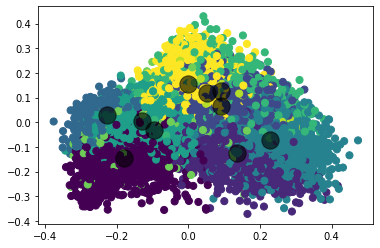

In [72]:
sklearn_pca = PCA(n_components = 10)
X_tf = sklearn_pca.fit_transform(tf_idf_array)
kmeans_func(X_tf)

# Using PCA and KMeans for Clustering

In [64]:
def kmeans_func(X):
    kmeans = KMeans(n_clusters=10, max_iter=600, algorithm = 'auto')
    fitted = kmeans.fit(X)  
    prediction = kmeans.predict(X)
    plt.scatter(X[:, 0], X[:, 1], c=prediction, s=50, cmap='viridis')
    centers = fitted.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1],c='black', s=300, alpha=0.6);

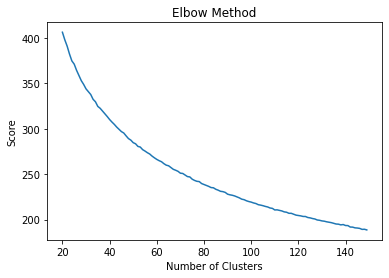

In [28]:
# May be around 60 clusters! That's a lot!
num_clusters = range(20,150)
kmeans = [KMeans(n_clusters =i,max_iter=600) for i in num_clusters]
score = [kmeans[i].fit(X).inertia_ for i in range(len(kmeans))]
plt.plot(num_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Method')
plt.show()

# Using LDA

In [26]:
cleaned_text = []
for t in text.values:
    line = t[0]
    line = line.translate(str.maketrans('','','1234567890'))
    cleaned_text.append(line)
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        
data_words = list(sent_to_words(cleaned_text))

d_words_temp = []
for d in data_words:
    if len(d) > 100000:
        d_words_temp.append(d[:100000])
    else:
        d_words_temp.append(d)
        
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']): #'NOUN', 'ADJ', 'VERB', 'ADV'
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Initialize spacy ‘en’ model, keeping only tagger component (for efficiency)
# Run in terminal: python -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])
# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(d_words_temp, allowed_postags=['NOUN', 'VERB']) #select noun and verb

In [132]:
with open('data.pkl', 'wb') as f:
    pickle.dump(data_lemmatized,f)


In [2]:
import pickle

with open('data.pkl', 'rb') as f:
     data_lemmatized = pickle.load(f)

In [4]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,
# minimum reqd occurences of a word 
                             stop_words='english',             
# remove stop words
                             lowercase=True,                   
# convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}')  
# num chars > 3
                             # max_features=50000,             
# max number of uniq words    )
data_vectorized = vectorizer.fit_transform(data_lemmatized)

In [5]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=20,               # Number of topics
                                      max_iter=10,               
# Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          
# Random state
                                      batch_size=128,            
# n docs in each learning iter
                                      evaluate_every = -1,       
# compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               
# Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)
print(lda_model)  # Model attributes

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=20, n_jobs=-1,
                          perp_tol=0.1, random_state=100, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)


In [27]:
# Create Document — Topic Matrix
lda_output = lda_model.transform(data_vectorized)
# column names
topicnames = ['Topic' + str(i) for i in range(lda_model.n_components)]
# index names
docnames = ['Doc' + str(i) for i in range(len(cleaned_text))]
# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)
# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic
# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)
def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)
# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,Topic15,Topic16,Topic17,Topic18,Topic19,dominant_topic
Doc0,0.000000,0.230000,0.000000,0.080000,0.010000,0.000000,0.300000,0.000000,0.150000,0.000000,0.000000,0.030000,0.000000,0.180000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,6
Doc1,0.000000,0.080000,0.000000,0.730000,0.000000,0.030000,0.000000,0.000000,0.000000,0.040000,0.000000,0.000000,0.070000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050000,3
Doc2,0.000000,0.000000,0.260000,0.000000,0.000000,0.080000,0.000000,0.000000,0.230000,0.000000,0.260000,0.000000,0.010000,0.000000,0.020000,0.020000,0.060000,0.060000,0.000000,0.000000,2
Doc3,0.160000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.110000,0.400000,0.290000,0.000000,0.000000,0.000000,0.020000,14
Doc4,0.040000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030000,0.000000,0.050000,0.000000,0.560000,0.210000,0.000000,0.000000,0.000000,0.000000,0.100000,13
Doc5,0.010000,0.150000,0.000000,0.010000,0.000000,0.000000,0.650000,0.000000,0.020000,0.000000,0.000000,0.020000,0.010000,0.000000,0.030000,0.000000,0.000000,0.010000,0.000000,0.090000,6
Doc6,0.000000,0.000000,0.000000,0.510000,0.070000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.080000,0.010000,0.010000,0.140000,0.000000,0.130000,0.000000,0.040000,0.000000,3
Doc7,0.000000,0.000000,0.000000,0.050000,0.020000,0.000000,0.350000,0.000000,0.260000,0.000000,0.000000,0.020000,0.060000,0.000000,0.000000,0.000000,0.120000,0.000000,0.120000,0.000000,6
Doc8,0.010000,0.000000,0.000000,0.150000,0.000000,0.000000,0.020000,0.000000,0.580000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.070000,0.160000,0.000000,0.000000,0.020000,8
Doc9,0.000000,0.000000,0.000000,0.410000,0.000000,0.010000,0.230000,0.090000,0.000000,0.220000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000,3


In [28]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(lda_model.components_)
# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames
# View
df_topic_keywords.head()

,aaa,aaaa,aaalac,aac,aad,aag,aahl,aand,aap,aatrna,...,zoonotic,zoos,zoster,zscore,zstack,zvadfmk,zygote,zyme,zymo,zymogen
Topic0,0.050000,0.05,0.050000,0.05,0.050000,0.050000,0.050000,0.05,0.05,0.05,...,0.05,0.05,0.05,0.05,0.05,0.05,0.050000,0.050000,0.05,0.05
Topic1,0.050000,0.05,17.779655,0.05,0.050000,0.050000,0.050000,0.05,0.05,0.05,...,0.05,0.05,0.05,0.05,0.05,0.05,16.810939,0.050000,0.05,0.05
Topic2,0.050000,0.05,0.050000,0.05,0.050000,0.050000,20.981437,0.05,0.05,0.05,...,0.05,0.05,0.05,0.05,0.05,0.05,0.050000,0.050000,0.05,0.05
Topic3,0.050006,0.05,0.050000,0.05,0.050000,21.242415,0.050000,0.05,0.05,0.05,...,0.05,0.05,0.05,0.05,0.05,0.05,0.050002,0.050000,0.05,0.05
Topic4,0.050000,0.05,20.599264,0.05,0.050004,0.050000,0.050000,0.05,0.05,0.05,...,0.05,0.05,0.05,0.05,0.05,0.05,13.754403,0.061299,0.05,0.05


In [30]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords
topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=15)
# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,health,disease,country,need,surveillance,include,research,provide,information,develop,response,outbreak,datum,development,use
Topic 1,group,pig,pedv,animal,day,study,sample,use,strain,chicken,calf,piglet,farm,control,virus
Topic 2,study,use,datum,include,effect,review,research,trial,report,analysis,intervention,article,number,author,outcome
Topic 3,sample,use,detection,primer,assay,detect,test,method,dna,reaction,virus,result,probe,target,amplification
Topic 4,virus,vaccine,infection,response,mouse,cell,use,antibody,induce,animal,day,challenge,vaccination,infect,study
Topic 5,use,activity,concentration,compound,effect,figure,drug,surface,particle,solution,result,acid,structure,group,value
Topic 6,sequence,virus,gene,strain,use,genome,region,analysis,mutation,isolate,identify,nucleotide,read,acid,study
Topic 7,protein,domain,structure,bind,interaction,site,virus,residue,membrane,figure,form,region,contain,replication,sequence
Topic 8,infection,patient,virus,study,case,child,year,age,influenza,report,symptom,disease,test,include,detect
Topic 9,use,datum,gene,analysis,method,set,value,number,model,identify,result,table,base,figure,network


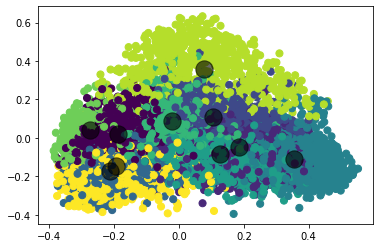

In [70]:
c_norm = normalize(c_vector)
c_array = c_norm.toarray()
sklearn_pca = PCA(n_components = 10)
X = sklearn_pca.fit_transform(c_array)
kmeans_func(X)

Projecting 10-dimensional data to 2D


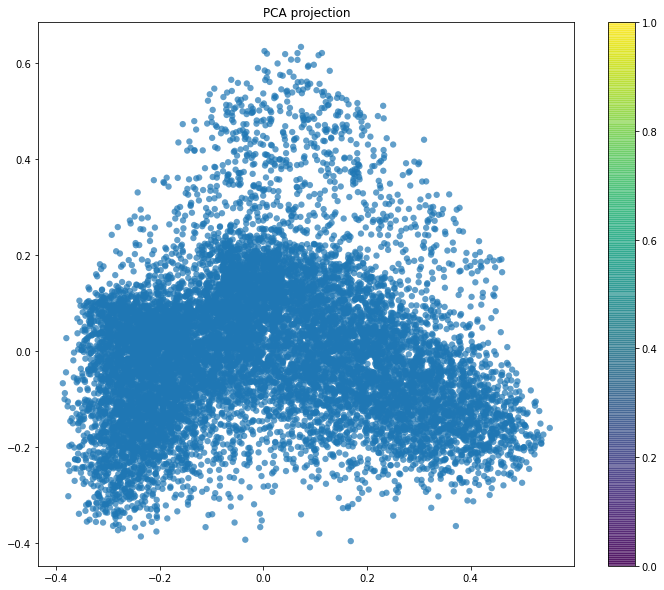

In [75]:
print('Projecting %d-dimensional data to 2D' % X.shape[1])

plt.figure(figsize=(12,10))
plt.scatter(X[:, 0], X[:, 1], 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('PCA projection');